# Analyzing the stability with the exact same software versions
Since we've seen that the codec, bitrate and version all have an effect on the variance of the label probabilities produced by the high level classifiers, another question to answer is **If we make sure that version, bitrate and codec are all the same, will the variance be significantly lower?**. In theory this should be the case, since the (hopefully) same input, ran through the same version of software (by different people) should produce the same output.

In [7]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

def filter_submissions(df):
    filt = df.groupby(level=0).size() > 1
    return df[filt[df.index.get_level_values(level=0)].values]

# Classifier columns to study
cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


# Load in the acousticbrainz dataset into the variable 'acousticbrainz' (V3 also include build SHA to make sure that software
# version is the same on a commit basis.
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
metaFeatureNames = [
    "analysis_sample_rate",
    "bit_rate",
    "codec",
    "downmix",
    "equal_loudness",
    "length",
    "lossless",
    "replay_gain"
]

highVersionFeatures = [
    "essentia",
    "essentia_build_sha",
    "essentia_git_sha",
    "extractor",
    "gaia",
    "gaia_git_sha",
    "models_essentia_git_sha"
]

lowVersionFeatures = [
    "essentia",
    "essentia_build_sha",
    "essentia_git_sha",
    "extractor"
]

for feat in highVersionFeatures:
    print(acousticbrainz[feat + '_high'].value_counts())
    print()
    

print()

for feat in lowVersionFeatures:
    print(acousticbrainz[feat + '_low'].value_counts())
    print()

2.1-beta1    1805912
Name: essentia_high, dtype: int64

8e24b98b71ad84f3024c7541412f02124a26d327    1805912
Name: essentia_build_sha_high, dtype: int64

v2.1_beta1-228-g260734a    1805912
Name: essentia_git_sha_high, dtype: int64

music 1.0    1805912
Name: extractor_high, dtype: int64

2.4-dev    1805912
Name: gaia_high, dtype: int64

857329b    1805912
Name: gaia_git_sha_high, dtype: int64

v2.1_beta1    1805912
Name: models_essentia_git_sha_high, dtype: int64


2.1-beta2    1142046
2.1-beta1     663866
Name: essentia_low, dtype: int64

2d9f1f26377add8aeb1075a9c2973f962c4f09fd    641078
70f2e5ece6736b2c40cc944ad0e695b16b925413    395517
ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b    306436
cead25079874084f62182a551b7393616cd33d87     52312
5c9e65ec81695c916afb4cba055c226bfc528ee6     37573
                                             ...  
c21bf699013b509032349ed6cc693ee6279a0082         3
52f73f7035b780910f2a0c20338a8d66a5befff1         2
317951e178f96928cbba401c6928c6ff93cb13a4       

In [9]:
acousticbrainz[acousticbrainz['essentia_low'] == '2.1-beta2']['essentia_git_sha_low'].value_counts()

v2.1_beta2-1-ge3940c0     693390
v2.1_beta2                408097
v2.1_beta2-2-gbb40004      36729
v2.1_beta2-15-g8ccb801      2355
v2.1_beta2-3-gd5e3a6e       1210
v2.1_beta2-6-gd3e4459        138
v2.1_beta2-12-g91c6a07       127
Name: essentia_git_sha_low, dtype: int64

In [10]:
acousticbrainz[acousticbrainz['essentia_git_sha_low'] == 'v2.1_beta2-1-ge3940c0']['essentia_build_sha_low'].value_counts()

2d9f1f26377add8aeb1075a9c2973f962c4f09fd    641078
cead25079874084f62182a551b7393616cd33d87     52312
Name: essentia_build_sha_low, dtype: int64

In [11]:
acousticbrainz[acousticbrainz['essentia_build_sha_low'] == '2d9f1f26377add8aeb1075a9c2973f962c4f09fd']['essentia_git_sha_low'].value_counts()

v2.1_beta2-1-ge3940c0    641078
Name: essentia_git_sha_low, dtype: int64

So there seem to be mulitple essentia git and essentia build SHAs for the same Essentia version, now we make subsets where all these fields are the same

In [12]:
grouped = acousticbrainz.groupby(['essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'bit_rate', 'codec'])
grouped = grouped.progress_apply(filter_submissions)
variances = grouped[cols].groupby(level=[0,1,2,3,4,5]).progress_apply(get_variance)
counts = pd.DataFrame(variances.groupby(level=[0,1,2,3,4]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances = variances.groupby(level=[0,1,2,3,4]).mean()

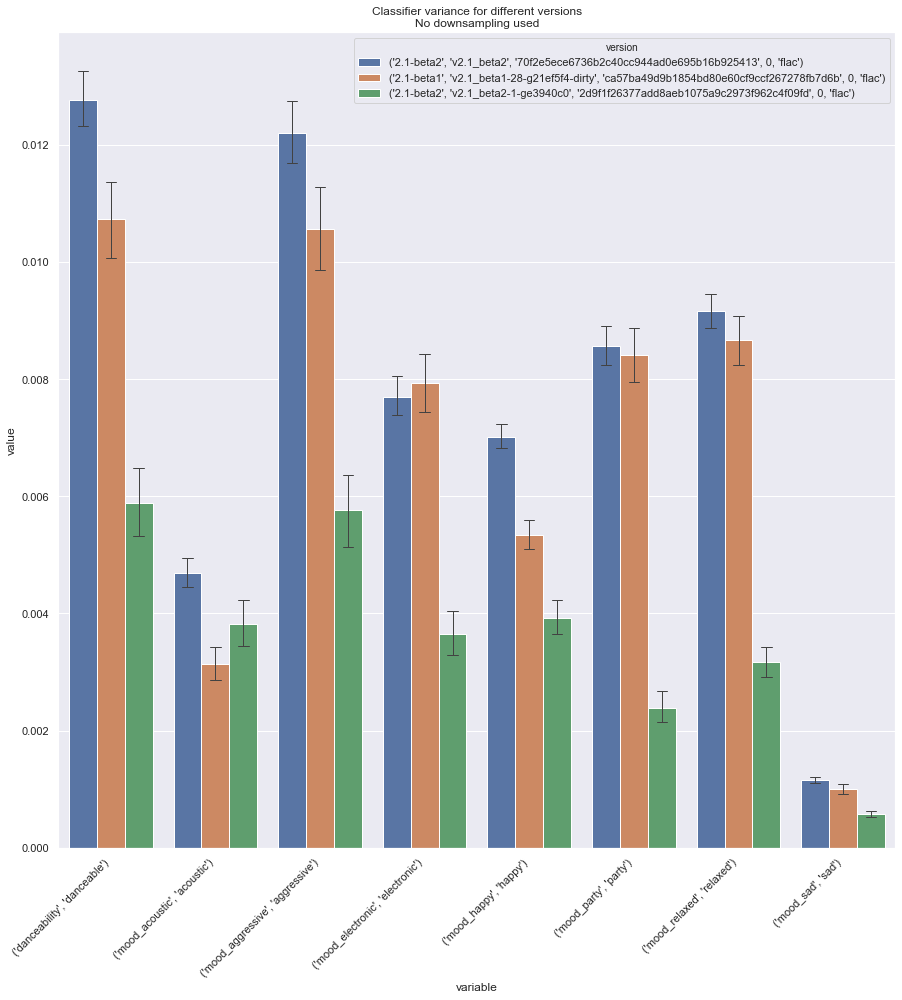

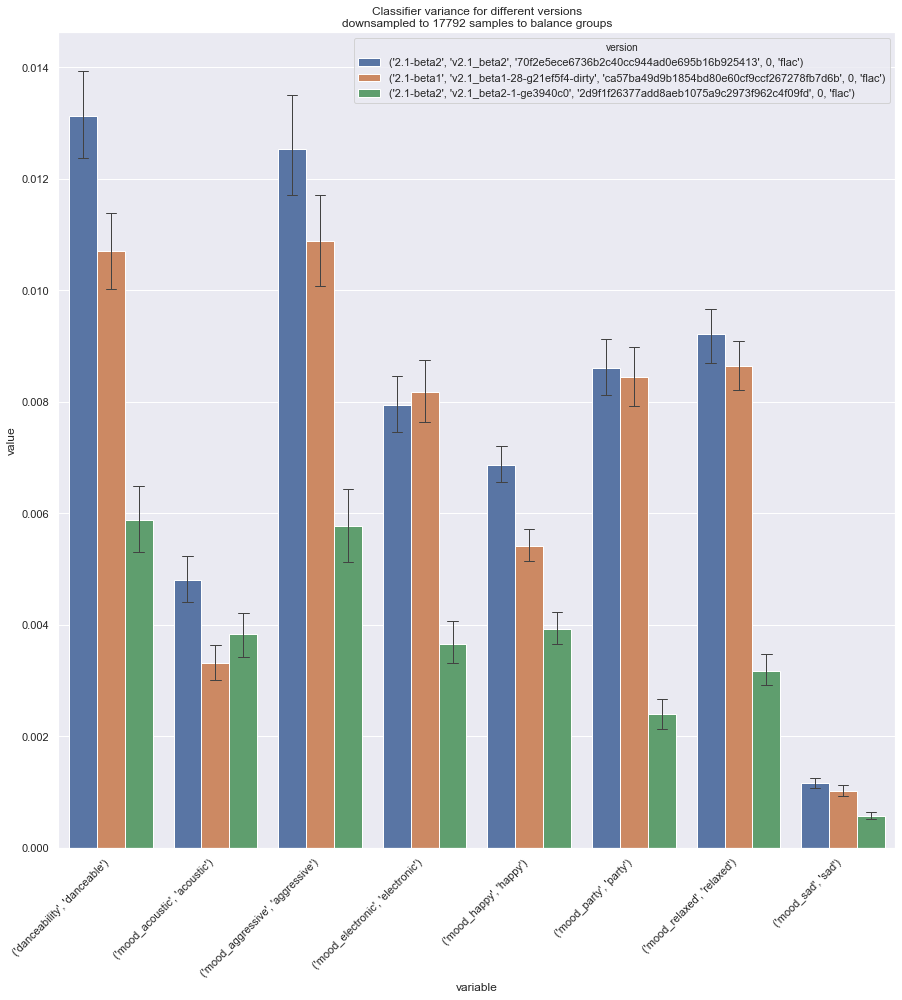

In [13]:
# Filter on version and codec combinations with more than 10,000 submissions
tocheck = list(counts[counts['count'] > 10000].index)
toplot = pd.DataFrame()
toplot_sampled = pd.DataFrame()

n_min = 20000
# Find lowest n
for comb in tocheck:
    n = len(variances.loc[comb])
    if n < n_min:
        n_min = n

for comb in tocheck:
    df = variances.loc[comb].reset_index(drop=True)
    df_sampled = df.sample(n_min)
    df['version'] = str(comb)
    df_sampled['version'] = str(comb)
    toplot = toplot.append(df)
    toplot_sampled = toplot_sampled.append(df_sampled)

toplot = toplot.melt(id_vars=['version'])
toplot_sampled = toplot_sampled.melt(id_vars=['version'])

plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different versions\nNo downsampling used")
plt.show()

plt.figure()
ax = sns.barplot(data=toplot_sampled, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for different versions\ndownsampled to {n_min} samples to balance groups")
plt.show()

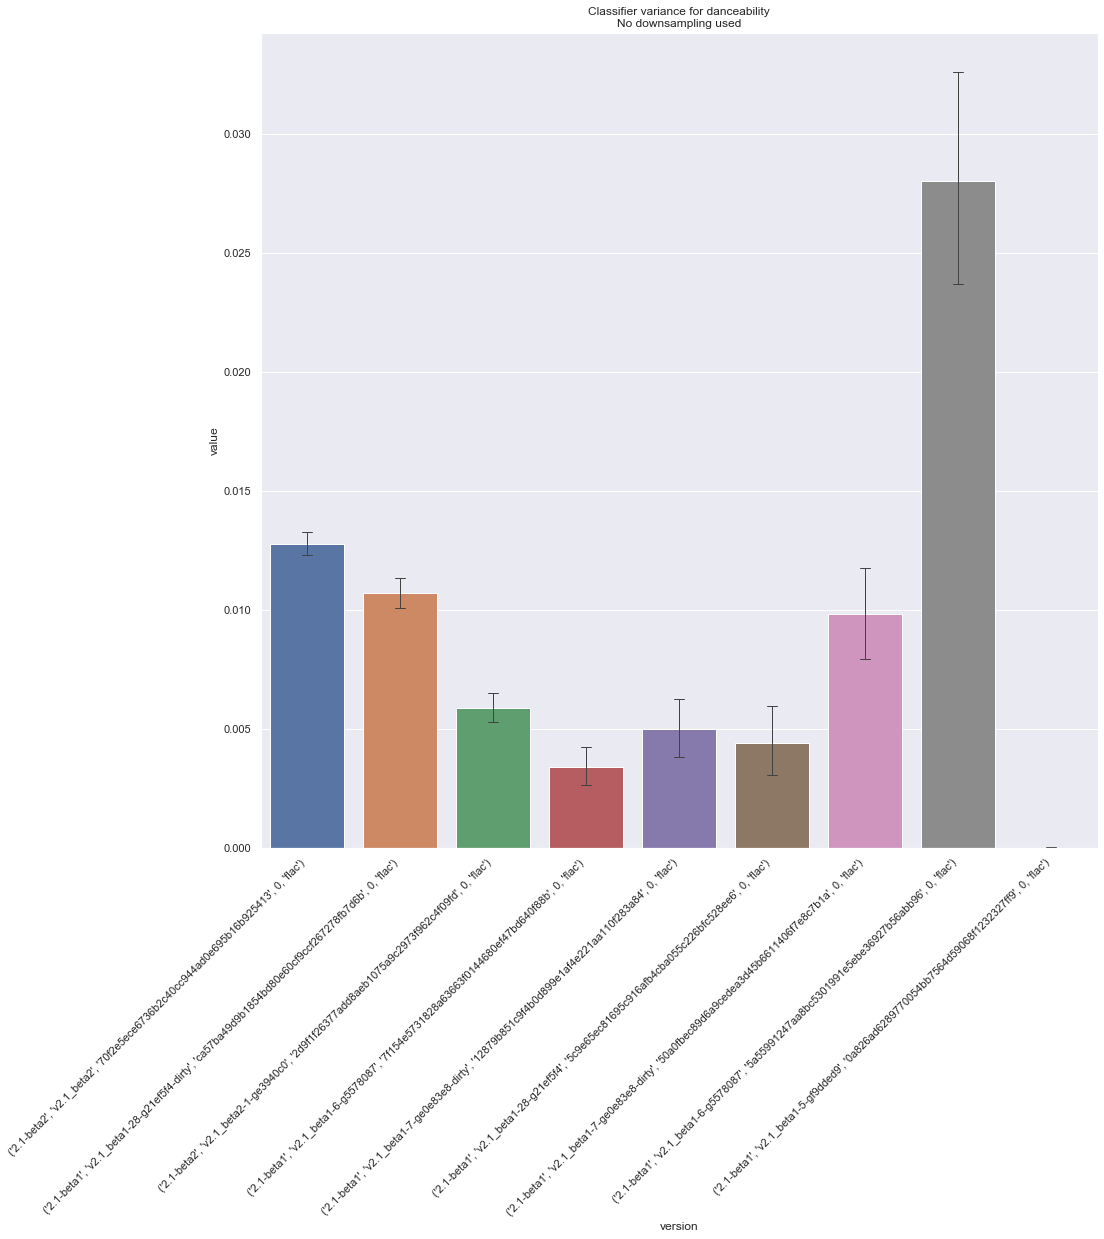

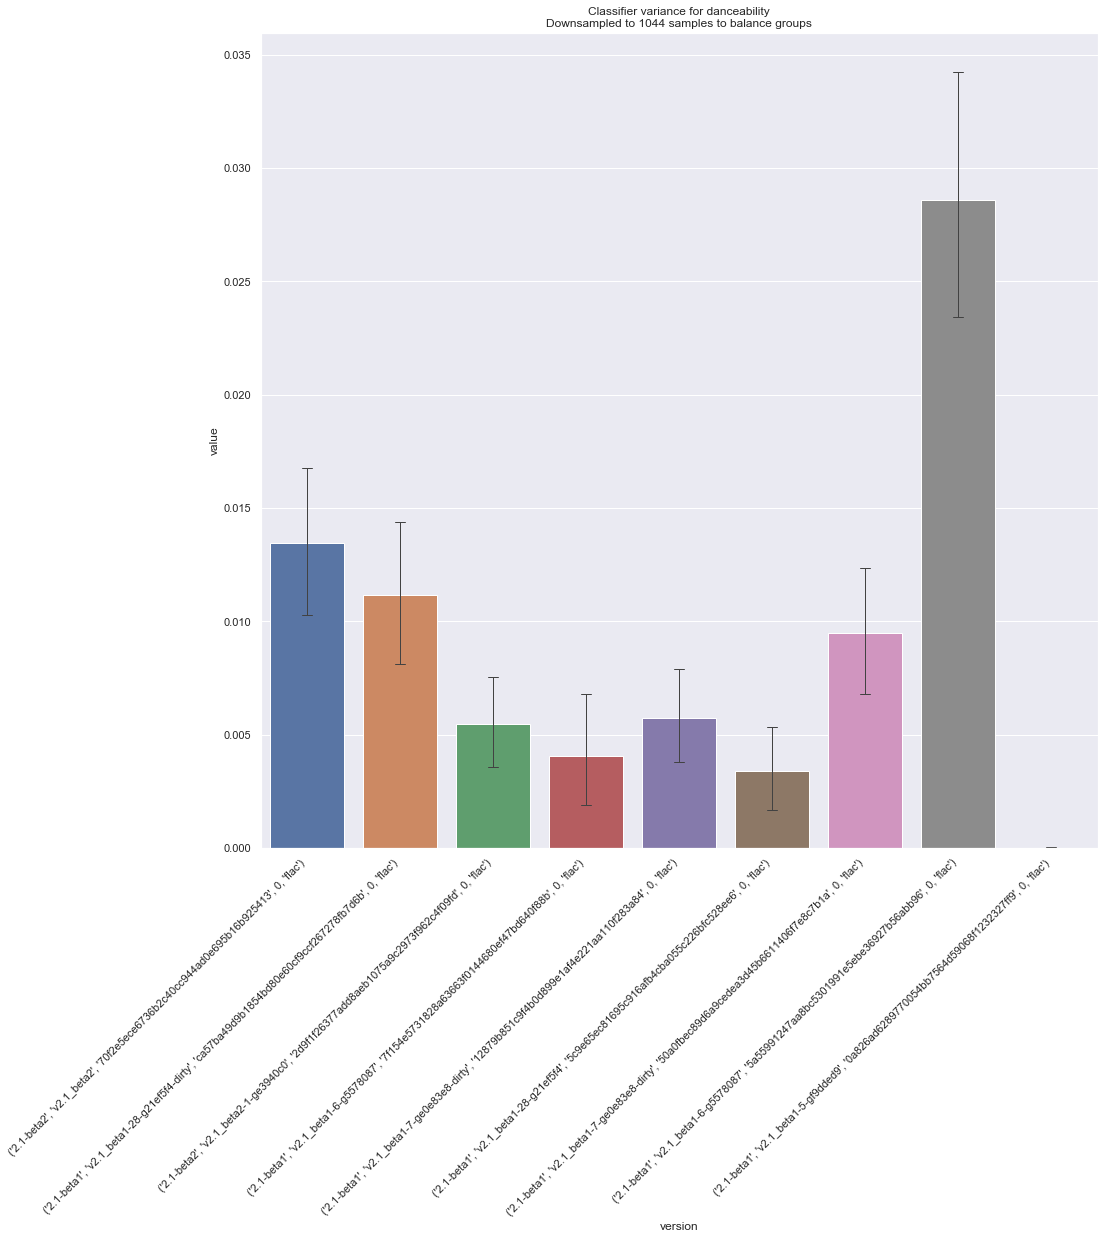

In [14]:
# Filter on version and codec combinations with more than 1,000 submissions using codec flac
tocheck = list(counts[counts['count'] > 1000].index)
tocheck = [x for x in tocheck if x[3] == 0 and x[4] == 'flac']

toplot = pd.DataFrame()
toplot_sampled = pd.DataFrame()

n_min = 20000
# Find lowest n
for comb in tocheck:
    n = len(variances.loc[comb])
    if n < n_min:
        n_min = n

for comb in tocheck:
    df = variances.loc[comb].reset_index(drop=True)
    df_sampled = df.sample(n_min)
    df['version'] = str(comb)
    df_sampled['version'] = str(comb)
    toplot = toplot.append(df)
    toplot_sampled = toplot_sampled.append(df_sampled)

toplot = toplot.iloc[:,[0,8]]
toplot = toplot.melt(id_vars=['version'])

toplot_sampled = toplot_sampled.iloc[:,[0,8]]
toplot_sampled = toplot_sampled.melt(id_vars=['version'])

plt.figure()
ax = sns.barplot(data=toplot, x='version', y='value', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for danceability\nNo downsampling used")
plt.show()

plt.figure()
ax = sns.barplot(data=toplot_sampled, x='version', y='value', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier variance for danceability\nDownsampled to {n_min} samples to balance groups")
plt.show()

# Stability on increasingly version granularities
In theory, the more specific the version (git SHA, build SHA), the lower we would expect the bitrate to be.
We look at three groups:
- Just the lowlevel essentia version + bitrate 0 + flac
- lowlevel essentia version + git SHA + bitrate 0 + flac
- lowlevel essentia version + git SHA + build SHA + bitrate 0 + flac

In [15]:
# Least specific versioning
grouped_least = acousticbrainz.groupby(['essentia_low', 'bit_rate', 'codec'])
grouped_least = grouped_least.progress_apply(filter_submissions)
variances_least = grouped_least[cols].groupby(level=[0,1,2,3]).progress_apply(get_variance)
counts_least = pd.DataFrame(variances_least.groupby(level=[0,1,2]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances_least = variances_least.groupby(level=[0,1,2]).mean()

# More specific versioning
grouped_more = acousticbrainz.groupby(['essentia_low', 'essentia_git_sha_low', 'bit_rate', 'codec'])
grouped_more = grouped_more.progress_apply(filter_submissions)
variances_more = grouped_more[cols].groupby(level=[0,1,2,3,4]).progress_apply(get_variance)
counts_more = pd.DataFrame(variances_more.groupby(level=[0,1,2,3]).size(), columns=['count']).sort_values(by='count', ascending=False)
pooledvariances_more = variances_more.groupby(level=[0,1,2,3]).mean()

# Most specific versioning (was already calculated)
grouped_most = grouped
variances_most = variances
counts_most = counts
pooledvariances_most = pooledvariances


In [53]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

display(counts_least)
display(counts_more)
print_full(counts_most)

count
essentia_low bit_rate codec       
2.1-beta1    0        flac   83424
2.1-beta2    0        flac   76329
             192000   mp3    21110
             128000   mp3    16437
             320000   mp3    11865
...                            ...
             148767   mp3        2
             148806   mp3        2
             148866   mp3        2
             148932   mp3        2
             2663305  alac       2

[18478 rows x 1 columns]

count
essentia_low essentia_git_sha_low         bit_rate codec       
2.1-beta2    v2.1_beta2                   0        flac   48101
2.1-beta1    v2.1_beta1-28-g21ef5f4-dirty 0        flac   22359
2.1-beta2    v2.1_beta2-1-ge3940c0        0        flac   18279
2.1-beta1    v2.1_beta1-6-g5578087        0        flac   11016
2.1-beta2    v2.1_beta2-1-ge3940c0        192000   mp3    10698
...                                                         ...
                                          192199   mp3        2
                                          192214   mp3        2
                                          192215   mp3        2
                                          192221   mp3        2
                                          206704   mp3        2

[16195 rows x 1 columns]

                                                                                                     count
essentia_low essentia_git_sha_low          essentia_build_sha_low                   bit_rate codec        
2.1-beta2    v2.1_beta2                    70f2e5ece6736b2c40cc944ad0e695b16b925413 0        flac    45835
2.1-beta1    v2.1_beta1-28-g21ef5f4-dirty  ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b 0        flac    22342
2.1-beta2    v2.1_beta2-1-ge3940c0         2d9f1f26377add8aeb1075a9c2973f962c4f09fd 0        flac    17792
                                                                                    192000   mp3     9997 
                                                                                    128000   mp3     9754 
2.1-beta1    v2.1_beta1-6-g5578087         7f154e5731828a63663f0144680ef47bd640f88b 0        flac    8202 
2.1-beta2    v2.1_beta2-1-ge3940c0         2d9f1f26377add8aeb1075a9c2973f962c4f09fd 320000   mp3     7967 
                                     

Let's plot the pooled variance for some versions with a lot of submissions

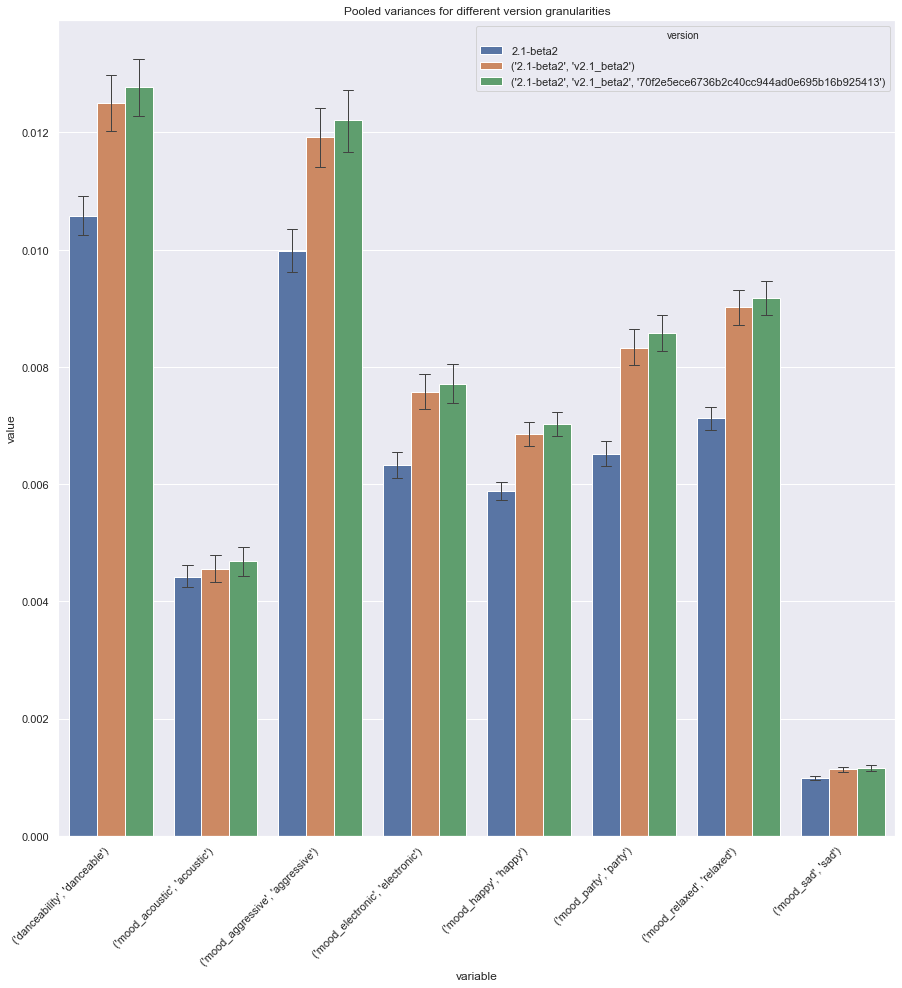

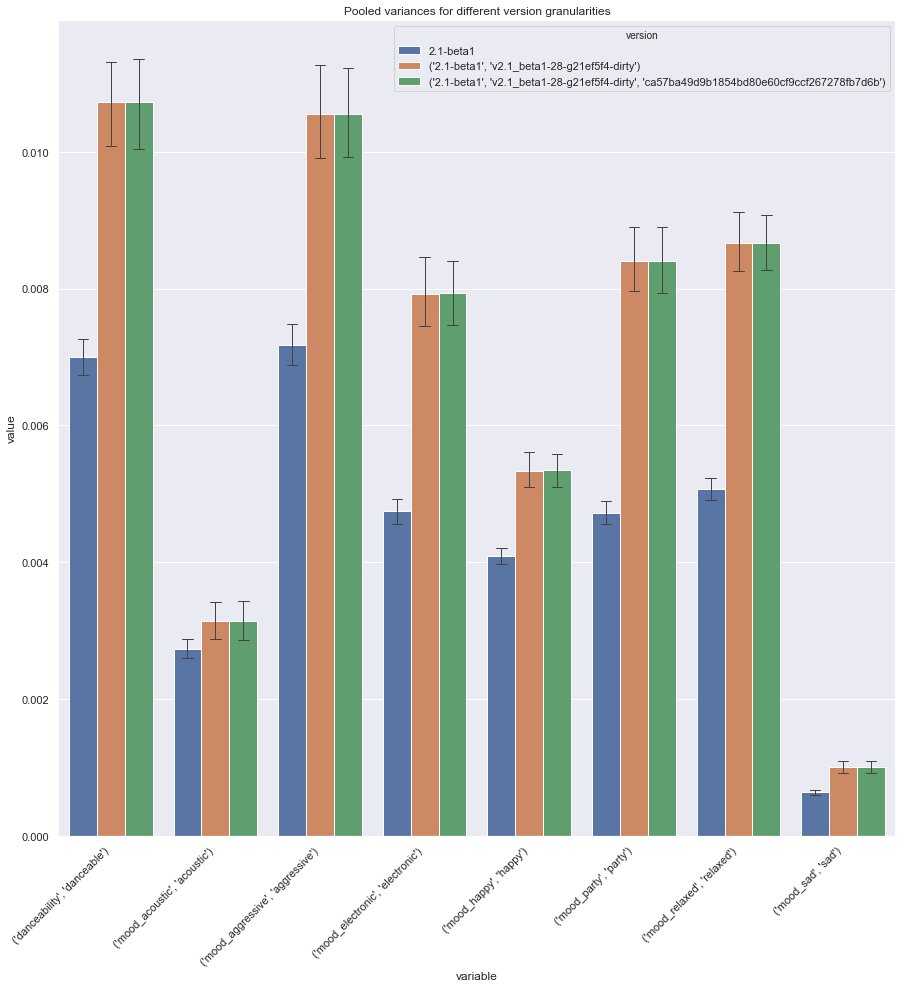

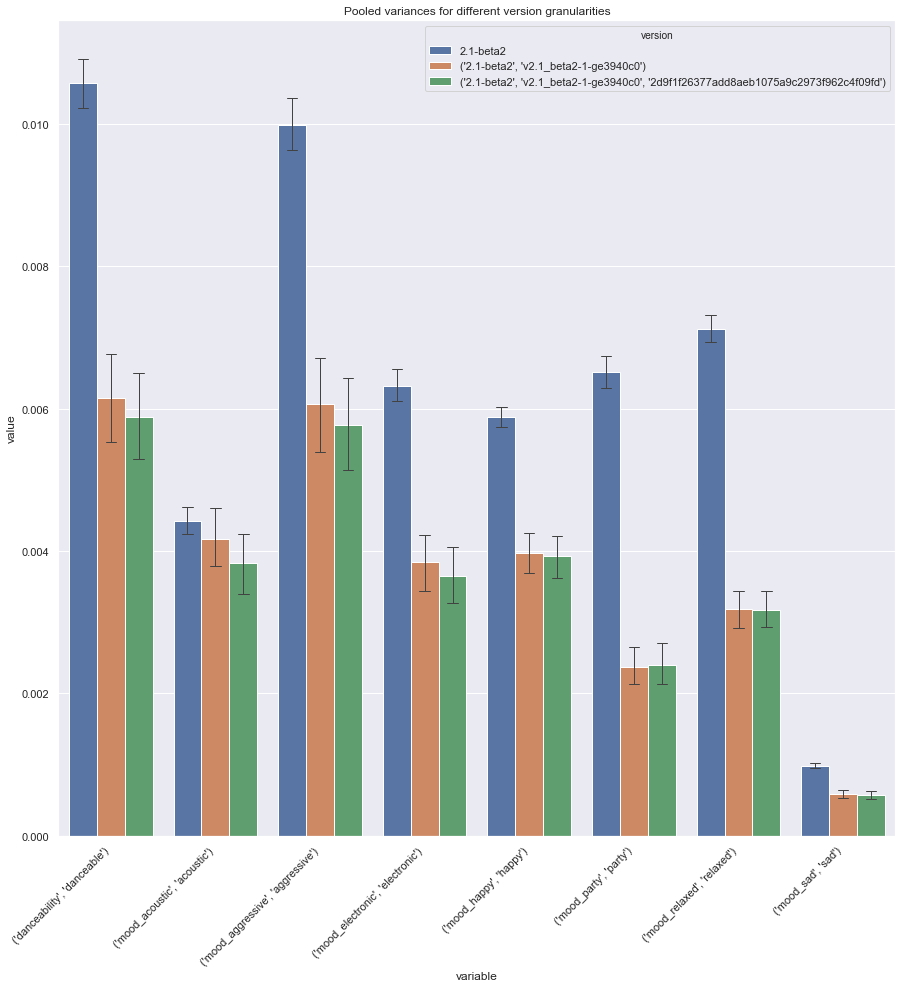

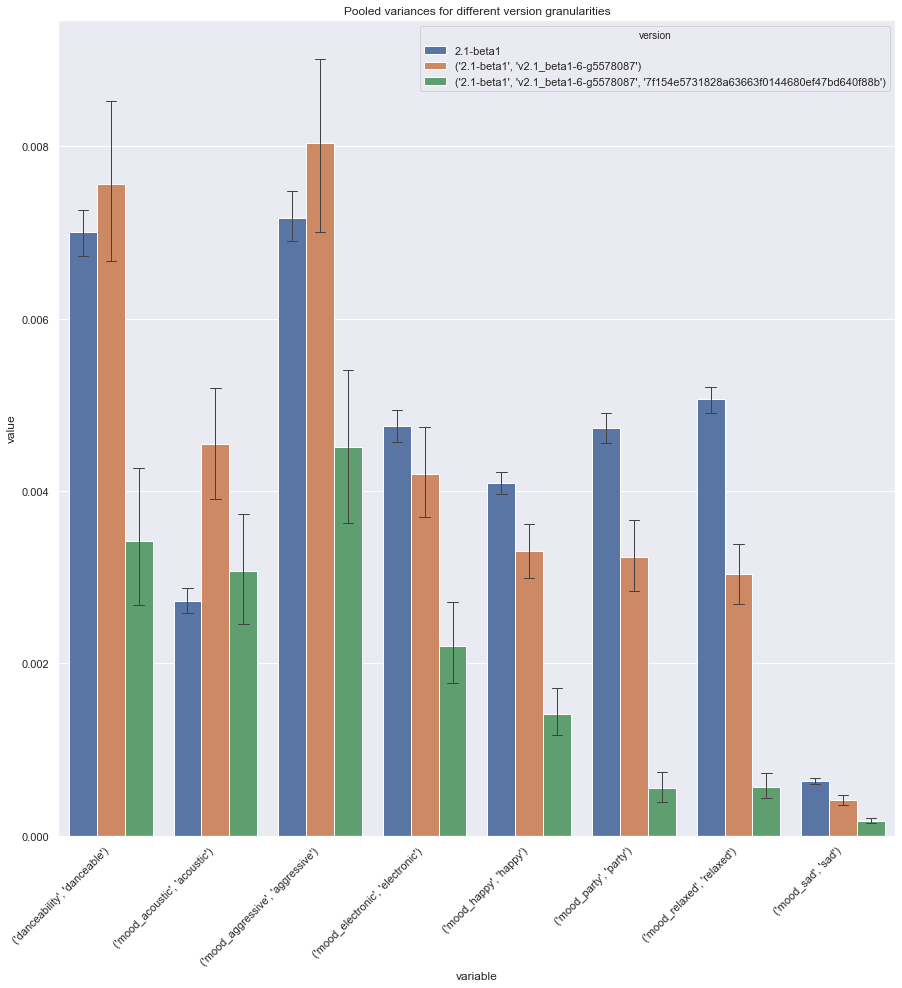

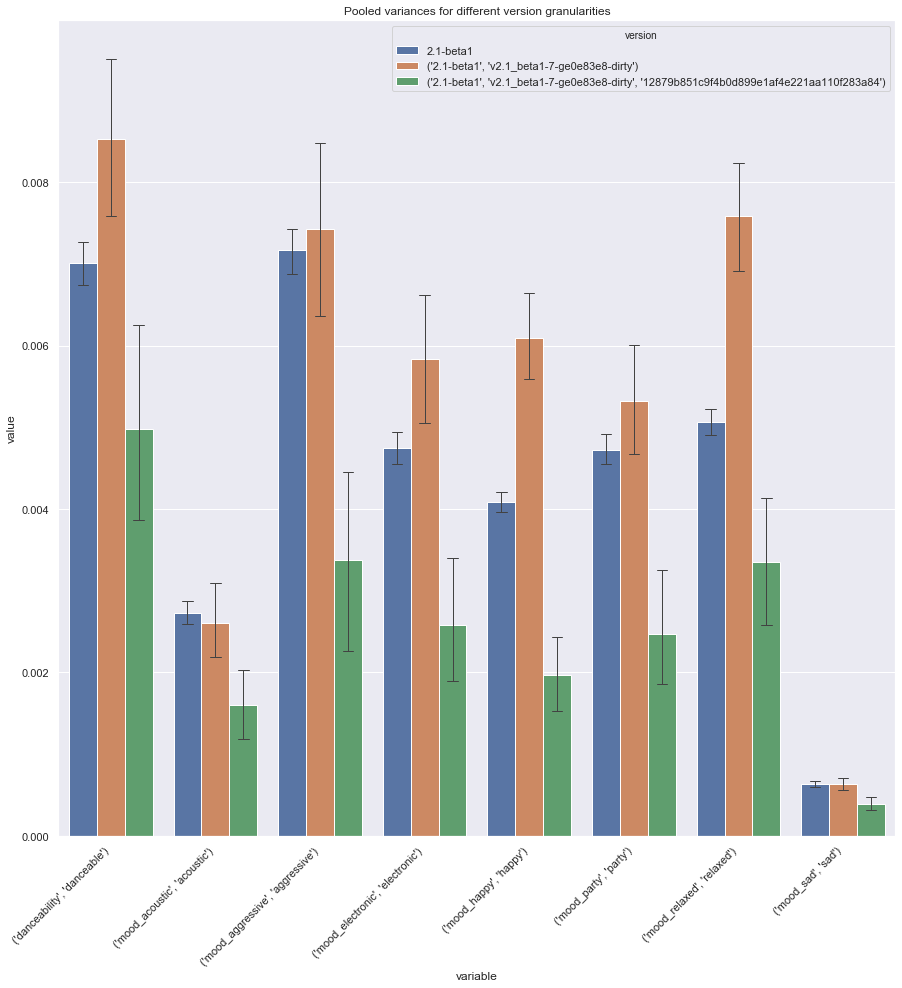

In [55]:
tocheck = [
    ('2.1-beta2', 'v2.1_beta2', '70f2e5ece6736b2c40cc944ad0e695b16b925413'),
    ('2.1-beta1', 'v2.1_beta1-28-g21ef5f4-dirty', 'ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b'),
    ('2.1-beta2', 'v2.1_beta2-1-ge3940c0', '2d9f1f26377add8aeb1075a9c2973f962c4f09fd'),
    ('2.1-beta1', 'v2.1_beta1-6-g5578087', '7f154e5731828a63663f0144680ef47bd640f88b'),
    ('2.1-beta1', 'v2.1_beta1-7-ge0e83e8-dirty', '12879b851c9f4b0d899e1af4e221aa110f283a84')
]

for version in tocheck:
    toplot_least = variances_least.loc[(version[0], 0, 'flac')]
    toplot_least['version'] = version[0]

    toplot_more = variances_more.loc[(version[0], version[1], 0, 'flac')]
    toplot_more['version'] = str((version[0], version[1]))

    toplot_most = variances_most.loc[(version[0], version[1], version[2], 0, 'flac')]
    toplot_most['version'] = str((version[0], version[1], version[2]))

    toplot = pd.concat([toplot_least, toplot_more, toplot_most])
    toplot = toplot.melt(id_vars='version')

    plt.figure()
    ax = sns.barplot(data=toplot, x='variable', y='value', hue='version', errwidth=1, capsize=.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f"Pooled variances for different version granularities")
    plt.show()

# Sanity check
As a quick sanity check, when using more granular version sets, does lossy vs. lossless still make a difference?

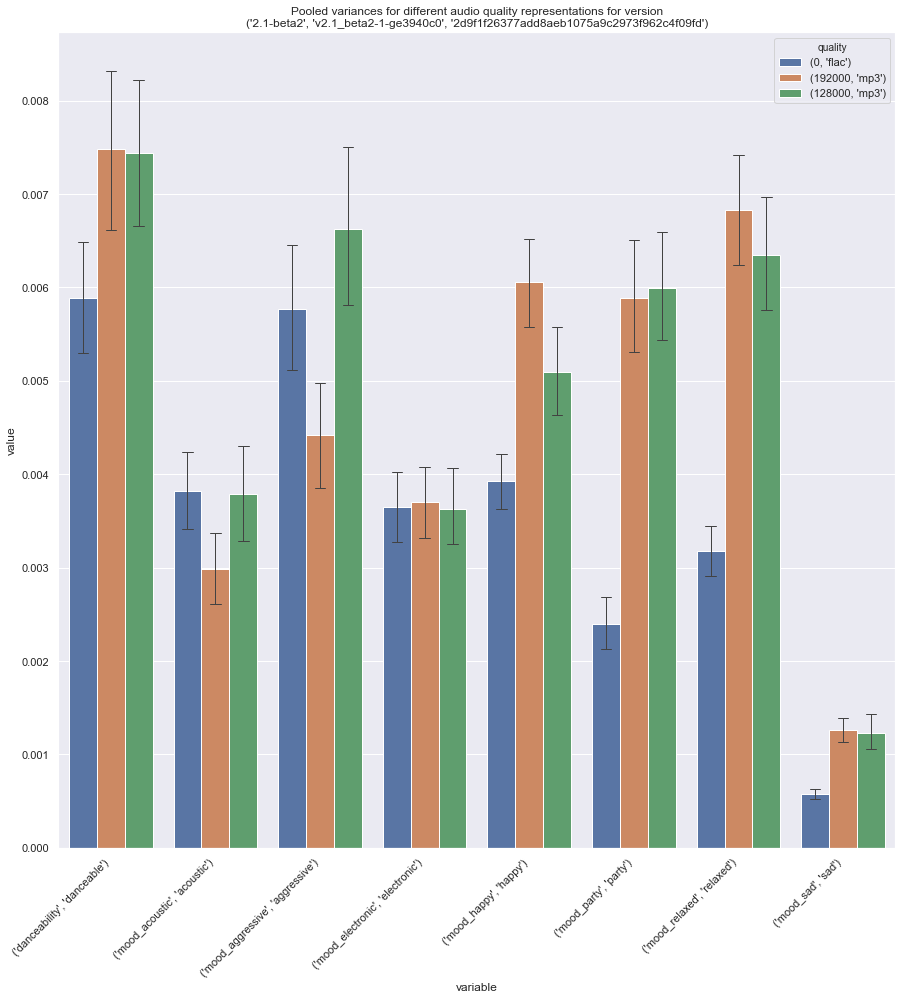

In [70]:
tocheck_ver = ('2.1-beta2', 'v2.1_beta2-1-ge3940c0','2d9f1f26377add8aeb1075a9c2973f962c4f09fd')
tocheck_qual = ((0, 'flac'), (192000, 'mp3'), (128000, 'mp3'))

toplot = pd.DataFrame()
for qual in tocheck_qual:
    df = variances_most.loc[(tocheck_ver[0], tocheck_ver[1], tocheck_ver[2], qual[0], qual[1])]
    df['quality'] = str(qual)
    toplot = toplot.append(df)

toplot = toplot.melt(id_vars=['quality'])

plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='quality', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Pooled variances for different audio quality representations for version\n{tocheck_ver}")
plt.show()

#### And for checking codec differences, filtering on the exact version only one comparison remains:

In [111]:
tocheck = counts_most.reset_index()
tocheck = (tocheck.groupby(['essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'bit_rate']).size() > 1).to_dict()

check = []
for (k, v) in tocheck.items():
    if v:
        check.append(k)

cnts = counts.reset_index()

tocheck = pd.DataFrame()
for chk in check:
    filtered_counts = cnts[(cnts['essentia_low'] == chk[0]) & (cnts['essentia_git_sha_low'] == chk[1]) & (cnts['essentia_build_sha_low'] == chk[2]) & (cnts['bit_rate'] == chk[3])]
    filtered_counts = filtered_counts[filtered_counts['count'] >= 100]
    if len(filtered_counts) > 1:
        tocheck = tocheck.append(filtered_counts)

tocheck

,essentia_low,essentia_git_sha_low,essentia_build_sha_low,bit_rate,codec,count
7,2.1-beta2,v2.1_beta2-1-ge3940c0,cead25079874084f62182a551b7393616cd33d87,320000,vorbis,5006
121,2.1-beta2,v2.1_beta2-1-ge3940c0,cead25079874084f62182a551b7393616cd33d87,320000,mp3,100


In [118]:
tocheck_ver = ('2.1-beta2', 'v2.1_beta2-1-ge3940c0', 'cead25079874084f62182a551b7393616cd33d87')
tocheck_qual = ((320000, 'vorbis'), (320000, 'mp3'))
n_min = 100

toplot = pd.DataFrame()
for qual in tocheck_qual:
    data = variances.loc[(tocheck_ver[0], tocheck_ver[1], tocheck_ver[2], qual[0], qual[1])]
    data['quality'] = str(qual)
    data = data.sample(n_min)
    toplot = toplot.append(data)

toplot = toplot.melt(id_vars=['quality'])

plt.figure()
ax = sns.barplot(data=toplot, x='variable', y='value', hue='quality', errwidth=1, capsize=.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Pooled variances for different audio quality representations for version\n{tocheck_ver}")
plt.show()

,quality,variable,value
0,"(320000, 'vorbis')","(danceability, danceable)",0.000000e+00
1,"(320000, 'vorbis')","(danceability, danceable)",3.976797e-03
2,"(320000, 'vorbis')","(danceability, danceable)",2.287529e-06
3,"(320000, 'vorbis')","(danceability, danceable)",9.878191e-06
4,"(320000, 'vorbis')","(danceability, danceable)",1.434000e-10
...,...,...,...
1595,"(320000, 'mp3')","(mood_sad, sad)",0.000000e+00
1596,"(320000, 'mp3')","(mood_sad, sad)",9.518146e-10
1597,"(320000, 'mp3')","(mood_sad, sad)",0.000000e+00
1598,"(320000, 'mp3')","(mood_sad, sad)",0.000000e+00
